### Libraries and includes
---

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras import models, layers, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

## Download and process the data set
---



##### Download from github

In [4]:
!git clone https://github.com/octavio-navarro/DL_Data_sets.git

Cloning into 'DL_Data_sets'...
remote: Enumerating objects: 49380, done.
remote: Counting objects: 100% (10080/10080), done.
remote: Compressing objects: 100% (10077/10077), done.
remote: Total 49380 (delta 4), reused 10078 (delta 2), pack-reused 39300
Receiving objects: 100% (49380/49380), 492.05 MiB | 35.55 MiB/s, done.
Resolving deltas: 100% (124/124), done.
Checking out files: 100% (49325/49325), done.


##### Show an image from the data set

(47, 49, 3)


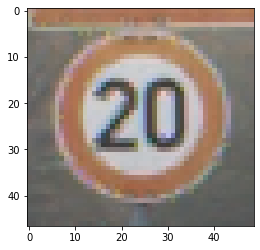

In [5]:
# TODO: Plot an image from the dataset using matplotlib
plot_image = cv2.imread('DL_Data_sets/German_Traffic_signs/Images/00000/00005_00020.ppm')
plot_image = cv2.cvtColor(plot_image, cv2.COLOR_BGR2RGB)

print(plot_image.shape)
plt.imshow(plot_image)
plot_image = cv2.resize(plot_image, dsize=(250, 250))

##### Separates the data into different folders

In [9]:
!pip install split-folders

In [10]:

import os, glob, random, math
import shutil 
import splitfolders

# TODO: Check out glob and copyfile, and create the test and train folders as needed. Each of the folders must have folders for each of the categories.

shutil.copytree('DL_Data_sets/German_Traffic_signs/', 'German_Traffic_Data/')

glob.glob('**')
splitfolders.ratio('DL_Data_sets/German_Traffic_signs/Images/', output="German_Data", seed=1337, ratio=(.8, .2), group_prefix=None) 
os.rename('German_Data/val','German_Data/test' )


Copying files: 39252 files [00:04, 7892.02 files/s]


In [11]:
!ls German_Data/test/00000/

00000_00004.ppm  00002_00025.ppm  00004_00009.ppm  00005_00021.ppm
00000_00016.ppm  00002_00029.ppm  00004_00016.ppm  00005_00024.ppm
00000_00027.ppm  00003_00000.ppm  00004_00026.ppm  00005_00028.ppm
00001_00000.ppm  00003_00002.ppm  00004_00029.ppm  00006_00001.ppm
00001_00012.ppm  00003_00003.ppm  00005_00002.ppm  00006_00002.ppm
00001_00013.ppm  00003_00008.ppm  00005_00004.ppm  00006_00007.ppm
00001_00022.ppm  00003_00010.ppm  00005_00008.ppm  00006_00015.ppm
00002_00003.ppm  00003_00012.ppm  00005_00012.ppm  00006_00018.ppm
00002_00018.ppm  00003_00013.ppm  00005_00018.ppm  00006_00019.ppm
00002_00019.ppm  00003_00018.ppm  00005_00019.ppm  00006_00027.ppm
00002_00020.ppm  00003_00027.ppm  00005_00020.ppm


## Model definition and training
---

##### Define and compile a model to classify the images. You can look at other models for inspiration.

In [12]:
# TODO: Define a model to classify the images. Don't forget to show its summary and compile it.

network = models.Sequential()

network.add(layers.Conv2D(64, (3,3), activation='relu', input_shape=(250, 250, 3)))
network.add(layers.Conv2D(64, (3,3), activation='relu'))
network.add(layers.MaxPooling2D((2,2)))

network.add(layers.Conv2D(128, (3,3), activation='relu'))
network.add(layers.Conv2D(128, (3,3), activation='relu'))
network.add(layers.MaxPooling2D((2,2)))


network.add(layers.Conv2D(356, (3,3), activation='relu'))
network.add(layers.Conv2D(356, (3,3), activation='relu'))
network.add(layers.Conv2D(356, (3,3), activation='relu'))
network.add(layers.MaxPooling2D((2,2)))
network.add(layers.Dropout(0.2))
network.add(layers.Conv2D(512, (3,3), activation='relu'))
network.add(layers.Conv2D(512, (3,3), activation='relu'))
network.add(layers.Conv2D(512, (3,3), activation='relu'))
network.add(layers.MaxPooling2D((2,2)))


network.add(layers.Conv2D(512, (3,3), activation='relu'))
network.add(layers.Conv2D(512, (3,3), activation='relu'))
network.add(layers.Conv2D(512, (3,3), activation='relu'))
network.add(layers.MaxPooling2D((2,2)))

network.add(layers.Flatten())
network.add(layers.Dropout(0.3))

network.add(layers.Dense(4096, activation='relu'))
network.add(layers.Dense(4096, activation='relu'))

network.add(layers.Dense(43, activation='softmax'))

network.summary()
network.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 248, 248, 64)      1792      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 246, 246, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 123, 123, 64)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 121, 121, 128)     73856     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 119, 119, 128)     147584    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 59, 59, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 57, 57, 356)      

#### Add data agumentation to the data set.

In [13]:
def gray_scale(image):
  '''
  image is rgb
  '''
  gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  return cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

##### Define the image data generator. Define transformations that make sense for the data set.

In [14]:
# TODO: Define an image data generator for training and for testing.

augmented_data_gen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = False,
    fill_mode = 'nearest',
    validation_split = 0.2
)

##### Define the train, validation, and test generators

In [15]:
# TODO: Create generators for training, validation, and testing.

train_generator = augmented_data_gen.flow_from_directory(
    'German_Data/train',
    target_size=(250, 250),
    batch_size=20,
    class_mode='categorical',
    subset='training'
)

validation_generator = augmented_data_gen.flow_from_directory(
    'German_Data/train',
    target_size=(250, 250),
    batch_size=20,
    class_mode='categorical',
    subset='validation'
)

test_generator = augmented_data_gen.flow_from_directory(
    'German_Data/test',
    target_size=(250, 250),
    batch_size=20,
    class_mode='categorical'
)

Found 25085 images belonging to 43 classes.
Found 6251 images belonging to 43 classes.
Found 7873 images belonging to 43 classes.


##### Using matplotlib, visualize images from the test generator. Create a figure of 20 images, with 5 images per row.

(250, 250, 3)


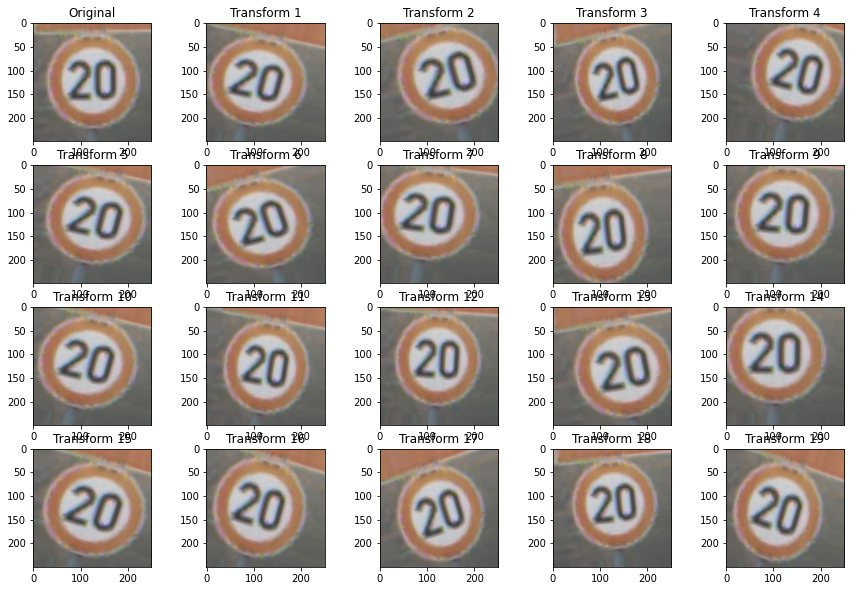

In [16]:
# TODO: Create a figure with images from the test generator.
image = cv2.imread('German_Data/test/00000/00005_00020.ppm')
plot_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plot_image = cv2.resize(plot_image, dsize=(250, 250))

plot_tensor = np.reshape(plot_image, (1, 250, 250 ,3))
print(plot_image.shape)


plt.figure(figsize=(15, 10))
plt.subplot(4, 5, 1)
plt.title('Original')
plt.imshow(plot_image)

idx = 1
for batch in augmented_data_gen.flow(plot_tensor, batch_size=1):
  plt.subplot(4, 5, idx+1)
  plt.title(f'Transform {idx}')
  plt.imshow(batch[0])
  idx += 1

  if idx % 20 == 0:
    break

plt.show()

##### Train the model using the generators. Investigate what 'Early stopping' is, and implement it for the training. Don't forget to use a GPU for training.

In [ ]:
# TODO: Train the model. Remember to use Early stopping.
# This callback will stop the training when there is no improvement in the loss for three consecutive epochs.
callback = callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = network.fit(
    train_generator,
    epochs=30,
    validation_data = validation_generator,
    callbacks=[callback],
    steps_per_epoch = train_generator.samples // 80,
    validation_steps = validation_generator.samples // 80
)

Epoch 1/30
313/313 [==============================] - 175s 558ms/step - loss: 3.5309 - accuracy: 0.0525 - val_loss: 3.5110 - val_accuracy: 0.0603
Epoch 2/30
313/313 [==============================] - 175s 557ms/step - loss: 3.5072 - accuracy: 0.0530 - val_loss: 3.4991 - val_accuracy: 0.0622
Epoch 3/30
313/313 [==============================] - 174s 555ms/step - loss: 3.2725 - accuracy: 0.0880 - val_loss: 3.2290 - val_accuracy: 0.0833
Epoch 4/30
313/313 [==============================] - 174s 557ms/step - loss: 3.0617 - accuracy: 0.1321 - val_loss: 3.2152 - val_accuracy: 0.1231
Epoch 5/30
313/313 [==============================] - 174s 557ms/step - loss: 2.9720 - accuracy: 0.1612 - val_loss: 3.1417 - val_accuracy: 0.1513
Epoch 6/30
313/313 [==============================] - 174s 556ms/step - loss: 2.6947 - accuracy: 0.2424 - val_loss: 2.3043 - val_accuracy: 0.3308
Epoch 7/30
313/313 [==============================] - 175s 558ms/step - loss: 1.8011 - accuracy: 0.4198 - val_loss: 1.7052 -

## Model evaluation
---

##### Evaluate the performance of the model with the test generator.

In [ ]:
# TODO: Evaluate the model, and print the results.
test_results = network.evaluate(test_generator, batch_size=20 )
print(test_results)

394/394 [==============================] - 137s 348ms/step - loss: 0.0907 - accuracy: 0.9732
[0.0907243862748146, 0.9731995463371277]


##### Plot the results of training: plot training and validation accuracy, and loss.

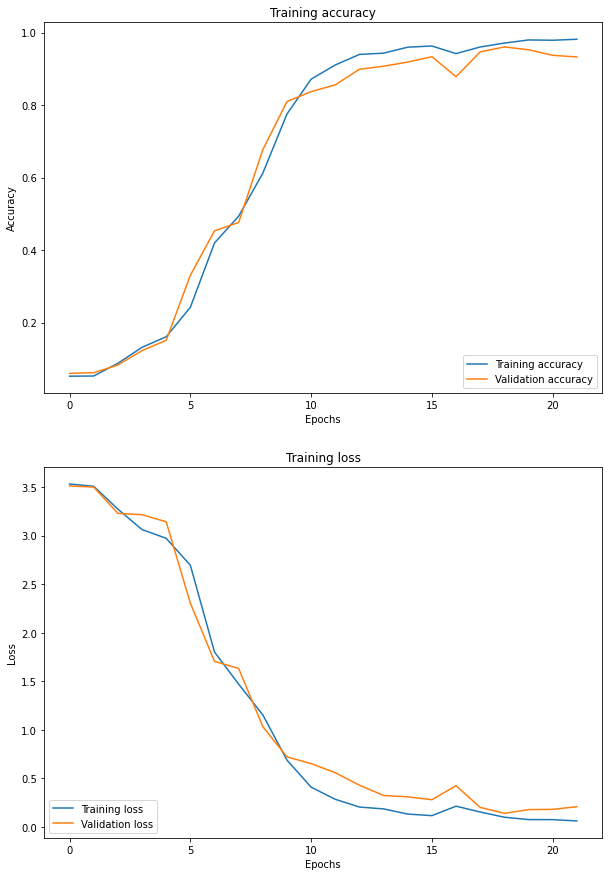

In [ ]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
fig, ax = plt.subplots(2, 1, figsize=(10, 15))

# TODO: Plot the results of the training and validation accuracy.

ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].plot(acc_values, label="Training accuracy")
ax[0].plot(val_acc_values, label="Validation accuracy")
ax[0].set_title("Training accuracy")
ax[0].legend(loc='lower right')

# TODO: Plot the results of the training and validation loss.

ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].plot(loss_values, label="Training loss")
ax[1].plot(val_loss_values, label="Validation loss")
ax[1].set_title("Training loss")
ax[1].legend(loc='lower left')